In [21]:
import pandas as pd
import glob
from shutil import copyfile, copytree
from PIL import Image, ImageFilter,  ImageOps
import os
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [14]:
"""
Read label and extract GSD
"""
files = glob.glob("valid_labels/labels/*.txt") #glob.glob("dataset/train/labelTxt/*.txt")
GSD = []
file_name = []
for file in files:
    with open(file, 'r') as f:
        file_name.append(file.split('\\')[-1])
        f.readline() # ignore first line
        txt = f.readline()
        if "null" not in txt:
            GSD.append(float(txt[4:-1]))
        else:
            GSD.append(0.0)

In [15]:
"""
Create pandas DataFrame for visualization
"""
df = pd.DataFrame({'filename': file_name, 'GSD': GSD})
df.describe()

,GSD
count,458.000000
mean,0.391985
std,0.366310
min,0.000000
25%,0.132483
50%,0.258030
75%,0.573301
max,2.246316


<Axes: ylabel='Frequency'>

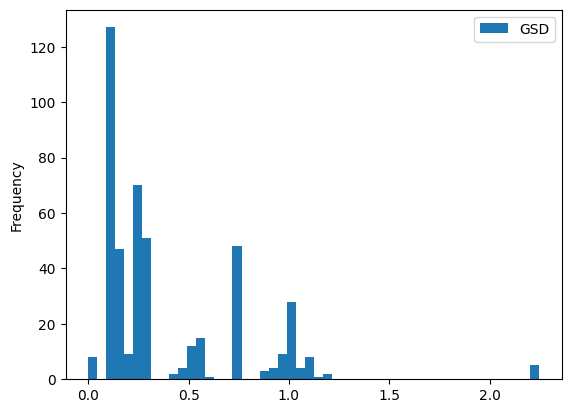

In [16]:
df.plot.hist(bins=50)

<Axes: ylabel='Frequency'>

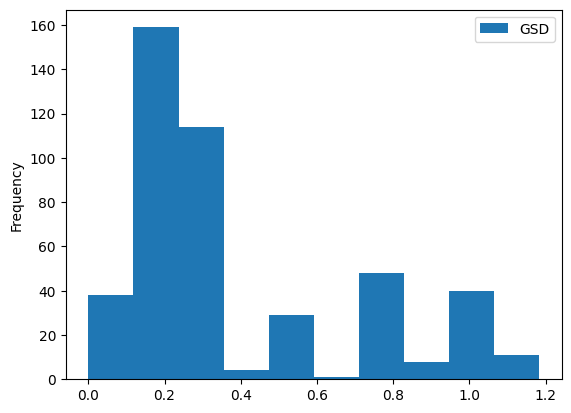

In [17]:
"""
Identify the images whose GSD is between 0 and 1.15 to have images with similar height
"""
df1 = df[df['GSD'] < 1.5]
df2 = df1[df1['GSD'] > 0]
df2.plot.hist(bins=10)

In [18]:
df2.describe()

,GSD
count,452.000000
mean,0.372401
std,0.312005
min,0.000001
25%,0.132358
50%,0.256553
75%,0.565680
max,1.182955


In [19]:
"""
Extract image and labels that are meeting the criteria above.
"""
for index, row in df2.iterrows():
    copyfile('valid/images/'+row['filename'].replace('txt', 'png'), 'valid/images_stage1/'+row['filename'].replace('txt', 'png'))
    copyfile('valid_labels/labels/'+row['filename'], 'valid_labels/labels_stage1/'+row['filename'])

In [20]:
df2

,filename,GSD
0,P0003.txt,0.115727
1,P0004.txt,0.132460
2,P0007.txt,0.127603
3,P0019.txt,0.108079
4,P0027.txt,0.223672
...,...,...
453,P2781.txt,0.105969
454,P2789.txt,0.102933
455,P2791.txt,0.217856
456,P2794.txt,0.104174


# Maintain res of 1024x1024 across all images

In [22]:
def preprocess_and_crop(path, file, target_res, height, width):
    """
    Preprocess images to a uniform resolution, then crop into patches.
    """
    # Open image
    im = Image.open(file)
    filename = os.path.splitext(os.path.basename(file))[0]
    
    # Rescale to target resolution
    im = ImageOps.fit(im, (target_res, target_res), method=Image.Resampling.LANCZOS)
    
    imgwidth, imgheight = im.size
    k = 0

    # Perform cropping
    for i in range(0, imgheight, height):
        for j in range(0, imgwidth, width):
            box = (j, i, j+width, i+height)
            cropped = im.crop(box)
            
            # Ensure final crop size matches desired dimensions
            if cropped.size != (width, height):
                cropped = ImageOps.pad(cropped, (width, height), color=(0, 0, 0))  # Black padding
            
            # Save cropped image
            cropped.save(os.path.join(path, f"{filename}-{k}.png"))
            k += 1

# Example usage
images_st1 = glob.glob("valid/images_stage1/*.png")
output_path = "valid/images_stage2"
target_resolution = 2048  # Rescale all images to 4096x4096
crop_height = 1024
crop_width = 1024

os.makedirs(output_path, exist_ok=True)
for img in images_st1:
    preprocess_and_crop(output_path, img, target_resolution, crop_height, crop_width)


In [23]:
"""
Go through image and remove images where black area is included
We consider image are invalid if any 4 corner of image is black
"""
import shutil

# Remove the directory if it exists
if os.path.exists('valid/images_stage3'):
    shutil.rmtree('valid/images_stage3')

# Copy the directory
shutil.copytree('valid/images_stage2', 'valid/images_stage3')

'valid/images_stage3'

## If the four corner pixels are black/nearly black, the image file is deleted using os.remove(img).

In [25]:
images_st3 = glob.glob("valid/images_stage3/*.png")
for img in images_st3:
    image = Image.open(img)
    width, height = image.size
    loc = ((0,0), (width-1,0), (0,height-1), (width-1,height-1))
    for x,y in loc:
        try:
            if sum(image.getpixel((x, y))) < 5:
                os.remove(img)
        except:
            continue
        break

# Create low resolution input images for traing Superresolution networks

In [27]:
"""
Create low resolution input 256x256
Also, create 1024 low res image with bicubic
"""
images_st3 = glob.glob("valid/images_stage3/*.png")
resample_method = [Image.BICUBIC, Image.NEAREST, Image.BOX, Image.BILINEAR, Image.HAMMING]
for img in images_st3:
    image = Image.open(img)
    reduced_img = image.resize((256,256), resample=resample_method[randrange(5)])
    reduced_img.save(img.replace('images_stage3', 'images_stage5'))

    upsample_img = reduced_img.resize((1024,1024), resample=Image.BICUBIC)
    upsample_img.save(img.replace('images_stage3', 'images_stage4'))